In [1]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 4070 Ti SUPER


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import accimage
import os
from PIL import Image
from torchvision import transforms

In [4]:
import random
# 再現性のためにランダムシードを設定
def set_seed(seed):
    random.seed(seed) # Python
    np.random.seed(seed) # NumPy
    torch.manual_seed(seed) # PyTorch
    # GPUを使う場合
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)  # 任意のシード値

acciimageはtorchvisionの画像読み込みバックエンド
直接Image()を使って画像を読み込むのではなく、PIL互換のオブジェクトとして扱う必要がある

In [5]:
%%time
image_path = "./data/images"

# 画像の前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_files = [f for f in os.listdir(image_path) if f.endswith(('.jpg'))]

image_tensors = []

for file in image_files:
    img = accimage.Image(os.path.join(image_path, file)) # PILで画像を開く
    img = transform(img) # 前処理を適用
    image_tensors.append(img)

image_tensors = torch.stack(image_tensors)

print(f"Loaded {len(image_tensors)} images as tensors.")

Loaded 10015 images as tensors.
CPU times: user 3min 10s, sys: 13.4 s, total: 3min 23s
Wall time: 47.4 s


In [6]:
img = Image.open("./data/images/ISIC_0024306.jpg")  # 画像を開く
print(img.mode)  # 画像のモードを確認

RGB


In [7]:
image_tensors.shape

torch.Size([10015, 3, 224, 224])

In [8]:
# PyTorchの CHWフォーマットになっているので、NumPy形式の NHWCフォーマットに変換する
image_tensors = image_tensors.numpy()  # Tensor → NumPy
image_tensors_numpy = np.transpose(image_tensors, (0, 2, 3, 1))  # CHW → HWC (Num_samples, Height, Width, Channels)
print(image_tensors_numpy.shape)

(10015, 224, 224, 3)


In [9]:
metadata = pd.read_csv("./data/HAM10000_metadata")
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [10]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [11]:
metadata_labels = metadata[['image_id', 'dx']]
metadata_labels

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [12]:
labels = metadata_labels['dx'].map({"akiec":0, "bcc":1, "bkl":2, "df":3, "mel":4, "nv":5, "vasc":6})
labels

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    4
Name: dx, Length: 10015, dtype: int64

In [13]:
labels_encoding = pd.get_dummies(labels, dtype=int)
labels_encoding

,0,1,2,3,4,5,6
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
10010,1,0,0,0,0,0,0
10011,1,0,0,0,0,0,0
10012,1,0,0,0,0,0,0
10013,1,0,0,0,0,0,0


In [14]:
import psutil
print(f"使用中メモリ: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

使用中メモリ: 14.93 GB


In [15]:
# メモリの削減
del image_tensors
import gc
gc.collect()

749

In [16]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(
    image_tensors_numpy, labels, test_size=0.3, stratify=labels, random_state=42
)

In [17]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)

train_data shape: (7010, 224, 224, 3)
train_labels shape: (7010,)
val_data shape: (3005, 224, 224, 3)
val_labels shape: (3005,)


In [18]:
class_names_mapping = {
    0: "AKIEC",
    1: "BCC",
    2: "BKL",
    3: "DF",
    4: "MEL",
    5: "NV",
    6: "VASC"
}

In [19]:
class_counts = np.sum(labels_encoding, axis=0)
class_counts

0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
dtype: int64

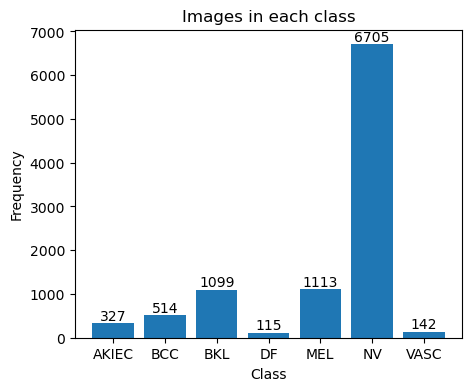

In [20]:
plt.figure(figsize=(5,4))
plt.bar([class_names_mapping[class_idx] for class_idx in range(len(class_names_mapping))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

for i,  count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')
plt.show()

In [21]:
unique_classes = np.unique(labels)
unique_classes

array([0, 1, 2, 3, 4, 5, 6])

In [22]:
labels.shape

(10015,)

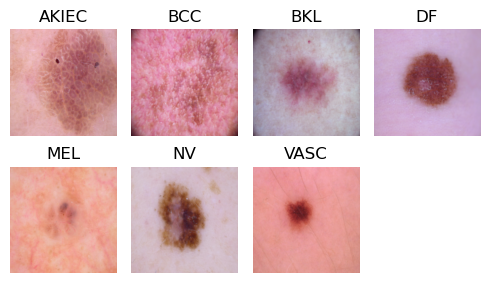

In [23]:
class_samples={}

for class_label in unique_classes:
    class_indices = np.where(labels==class_label)[0] # クラスのインデックス取得
    class_samples[class_label]=image_tensors_numpy[class_indices[0]]

plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_name = class_names_mapping[class_label] # クラス名取得
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
labels = pd.get_dummies(metadata_labels['dx'], dtype='int')
print(labels.shape)
labels

(10015, 7)


,akiec,bcc,bkl,df,mel,nv,vasc
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
10010,1,0,0,0,0,0,0
10011,1,0,0,0,0,0,0
10012,1,0,0,0,0,0,0
10013,1,0,0,0,0,0,0


## XceptionNet の事前学習済みモデルを適用してみる

- 学習データの拡張はImageNetとそろえる

In [25]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

- このあと、普通に適用としたらエラーになるので、Datasetクラスを作成して適用させる
- （通常、このtransformはPIL.ImageやTensorに適用されるため）

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        dataはnumpy.darrrayの画像データ（N, H, W, C)
        labelsはnumpy.darrayのラベルデータ（N, ）
        transformは定義した画像変換処理
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) # (C, H, W)の順にする
        return image, torch.tensor(label, dtype=torch.long) # labelはlong型

IndentationError: unexpected indent (2680012158.py, line 2)

In [27]:
train_labels = train_labels.values  # Pandas Series → NumPy 配列
val_labels = val_labels.values      # 検証データも同様に変換

- torch.long型は整数系（int64）

In [28]:
batch_size = 32

train_dataset = CustomDataset(train_data, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_data, val_labels, transform=val_transform)

In [29]:
# CPUのコア数を確認
import os
os.cpu_count()  # コア数

20

In [30]:
# 訓練用データ
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
# 検証用データ
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [31]:
%%skip(reason)
# 学習済みのXceptionNetをロードしてくる
import timm
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが利用可能なら使用

num_classes = len(set(train_labels)) # クラス数
model = timm.create_model("legacy_xception", pretrained=True, num_classes=num_classes) # 学習済み
model = model.to(device)

UsageError: Cell magic `%%skip(reason)` not found.


In [32]:
import mlflow
import mlflow.pytorch

# MLflow のトラッキング URI を設定
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# MLflow の実験を設定
mlflow.set_experiment("250311_xceptionnet")

<Experiment: artifact_location='/works/mlruns/1', creation_time=1741694676407, experiment_id='1', last_update_time=1741694676407, lifecycle_stage='active', name='250311_xceptionnet', tags={}>

In [ ]:
%%skip(reason)
import torch.optim as optim
def train(model):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが利用可能なら使用
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device) # 損失関数
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    with mlflow.start_run() as run:  # 実験を開始し、run を取得
        run_id = run.info.run_id  # 実行 ID を取得
        print(f"Run ID: {run_id}")  # Run ID を確認

        mlflow.log_param("learning_rate", 0.01)

        for epoch in range(10):  # 3エポックの学習
            running_loss = 0.0
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)  # GPU に転送
                optimizer.zero_grad()  # 勾配を初期化
                outputs = model(images)  # 順伝播
                loss = criterion(outputs, labels)  # 損失計算
                loss.backward()  # 逆伝播
                optimizer.step()  # パラメータ更新

                running_loss += loss.item()

            mlflow.log_metric("loss", running_loss / len(train_loader), step=epoch)  # MLflow に損失を記録

        mlflow.pytorch.log_model(model, "model")  # 訓練済みモデルを保存

    return run_id  # 実行 ID を返す

# 訓練を実行
run_id = train(model)

一気に推論まで行ってくれるようにコードを書いてみる

In [ ]:
%%skip(reason)
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def objective(train_loader, val_loader, num_classes):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available else "cpu"

    model = timm.create_model(
        "legacy_xception", pretrained=True, num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    with mlflow.start_run() as run:  # 実験を開始し、run を取得
        run_id = run.info.run_id  # 実行 ID を取得
        print(f"Run ID: {run_id}")  # Run ID を確認

        mlflow.set_tag("model", "xceptionnet")
        mlflow.set_tag("dataset", "HAM10000")
        
        mlflow.log_param("learning_rate", 0.0001)

        best_val_loss = float("inf")
        best_epoch = 0
        best_acc = 0  # 最良の検証精度
        best_model_state = None  # モデルの状態を保存するための変数

    for epoch in range(10):
        # 訓練モード
        model.train()
        train_loss = 0
        train_correct = 0
        total_samples = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            #labels = labels.squeeze().long()  # ラベルを1Dに変換し、整数型にキャスト
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)

            train_loss += loss.item() * batch_size
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += batch_size

        train_loss /= total_samples
        train_acc = train_correct / total_samples

        mlflow.log_metric("train_loss", train_loss, step=epoch)  # MLflow に損失を記録
        mlflow.log_metric("train_acc", train_acc, step=epoch)  # MLflow にaccを記録

        # 検証モード
        model.eval()
        val_loss = 0
        val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                #labels = labels.squeeze().long()  # ラベルを1Dに変換
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                batch_size = labels.size(0)
                val_loss += loss.item() * batch_size
                val_correct += (outputs.argmax(1) == labels).sum().item()
                total_val_samples += batch_size
        
        val_loss /= total_val_samples
        val_acc = val_correct / total_val_samples

        mlflow.log_metric("val_loss", val_loss, step=epoch)  # MLflow に損失を記録
        mlflow.log_metric("val_acc", val_acc, step=epoch)  # MLflow にaccを記録

        # ベストモデルを記録
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_acc = val_acc
            best_model_state = model.state_dict()
            example_input = torch.randn(1, 3, 224, 224)  # 1枚の画像（RGB, 224x224）
            mlflow.pytorch.log_model(model, "best_model", pip_requirement=None)

        mlflow.log_metric("best_val_loss", best_val_loss)
        mlflow.log_metric("best_epoch", best_epoch)
        mlflow.log_metric("best_acc", best_acc)

        # 学習率スケジューラを更新
        scheduler.step()

        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
    return best_epoch, best_val_loss, best_acc, best_model_state

In [ ]:
%%skip(reason)
# モデルを学習・検証
num_classes = len(set(train_labels))
best_epoch, best_val_loss, best_acc, best_model_state = objective(train_loader, val_loader, num_classes)

print("Best Epoch:", objective.best_epoch)
print("Best Val Loss:", objective.best_val_loss)
print("Best Acc:", objective.best_acc)

## 管理用に分けてかいてみる

In [33]:
# モデルを定義
import timm
import torch.nn as nn

num_classes = len(set(train_labels))
def create_model(model_name="legacy_xception", num_classes=num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model

In [40]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_correct = 0
    total_samples = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        train_loss += loss.item() * batch_size 
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += batch_size
    
    train_loss /= total_samples
    train_acc = train_correct/ total_samples
    return train_loss, train_acc

In [41]:
def evaluate(model, cal_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            #labels = labels.squeeze().long()  # ラベルを1Dに変換
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_val_samples += batch_size
        
    val_loss /= total_val_samples
    val_acc = val_correct / total_val_samples
        
    return val_loss, val_acc,

In [42]:
# モデルの作成・訓練・評価・ログ記録
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def objective(train_loader, val_loader, num_classes, num_epochs):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = create_model(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer =optim.Adam(model.parameters(), lr=0.0001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_loss = float("inf")
    best_epoch = 0
    best_acc = 0
    best_model_state = None

    with mlflow.start_run() as run:
        mlflow.log_param("learning_rate", 0.0001)

        for epoch in range(num_epochs):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_acc", val_acc, step=epoch)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                best_acc = val_acc
                best_model_state = model.state_dict()
                mlflow.pytorch.log_model(model, "best_model")
                
            scheduler.step()

            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return best_epoch, best_val_loss, best_acc, best_model_state            


In [43]:
num_epochs = 10
best_epoch, best_val_loss, best_acc, best_model_state = objective(train_loader, val_loader, num_classes, num_epochs)

print("Best Epoch:", best_epoch)
print("Best Val Loss:", best_val_loss)
print("Best Acc:", best_acc)
print("Best Model Sate:", best_model_state)

🏃 View run rumbling-mink-93 at: http://127.0.0.1:5000/#/experiments/1/runs/7efbb5572d754055a96902a095d85f36
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


TypeError: conv2d() received an invalid combination of arguments - got (JpegImageFile, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!JpegImageFile!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!JpegImageFile!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
